# SARIMAX model

## Overview

This notebook presents our SARIMAX-based forecasting pipeline, implemented using Nixtla’s **`statsforecast`** library. The model combines a linear regression on carefully engineered exogenous variables (such as temperature, calendar features, and Fourier terms) with a **Seasonal ARIMA** (SARIMA) component that captures residual autocorrelation. The primary goal is to build, tune, and evaluate forecasting models for five previously analyzed time series (F1 to F5), across both **daily** and **weekly** forecast horizons. The entire modeling process is encapsulated within the `SARIMAXPipeline` class.

### Model Specification

Given a target series $y_t$ and a vector of $k$ exogenous regressors $\mathbf{x}_t=(x_{1,t},\dots,x_{k,t})^{\top}$, the SARIMAX model is defined as:


$$
y_t = \beta_0 + \boldsymbol{\beta}^{\!\top} \mathbf{x}_t + \eta_t,\qquad
\eta_t \sim \text{SARIMA}(p,d,q)\times(P,D,Q)_s,
$$

with the SARIMA residual term $\eta_t$ satisfying:

$$ \Phi_P(B^{s})\,\phi_p(B)\,(1-B)^d(1-B^{s})^{D}\,\eta_t = 
\Theta_Q(B^{s})\,\theta_q(B)\,\varepsilon_t,\qquad
\varepsilon_t \stackrel{\text{i.i.d.}}{\sim} \mathcal{N}(0,\sigma^{2}),
$$

where $B$ denotes the backshift operator, $B\eta_t = \eta_{t-1}$. The polynomials are defined as:

* **Non-seasonal AR:** $\phi_p(B) = 1 - \phi_1 B - \dots - \phi_pB^p$
* **Seasonal AR:** $\Phi_P(B^{s}) = 1 - \Phi_1 B^{s} - \dots - \Phi_PB^{Ps}$
* **Non-seasonal MA:** $\theta_q(B) = 1 + \theta_1 B + \dots + \theta_qB^q$
* **Seasonal MA:** $\Theta_Q(B^{s}) = 1 + \Theta_1 B^{s} + \dots + \Theta_QB^{Qs}$

This model captures both short-term dynamics and recurring seasonal patterns. The autoregressive (AR) terms capture the influence of past observations, while the moving average (MA) terms account for past forecast errors. Differencing terms (both seasonal and non-seasonal) help make the series stationary and easier to model.

Nixtla’s implementation estimates model parameters via exact maximum likelihood. Additionally, the API provides an `AutoARIMA` routine that automatically selects optimal $(p,d,q,P,D,Q)$ values by minimizing the corrected Akaike Information Criterion (AICc).

### Why SARIMAX?

SARIMAX was chosen for its balance of interpretability, flexibility, and compatibility with exogenous features. Unlike pure time series models, SARIMAX allows the inclusion of covariates, making it particularly well-suited for structured forecasting tasks where external drivers (e.g., weather) are important.

While the model offers strong performance and transparency, it does have limitations. In particular, feature engineering is manual and critical: the linear regression component cannot automatically extract useful signals from raw features. This stands in contrast to deep learning models, which can often discover non-linear patterns in high-dimensional feature spaces with minimal preprocessing.

**Key Features of Our Implementation**:

* **Daily seasonality** is captured through the SARIMA residual component, enabling a flexible and adaptive structure for evolving intraday dynamics, unlike fixed-pattern methods such as Fourier series.
* **Weekly seasonality** is explicitly modeled using exogenous Fourier terms, which effectively encode recurring weekly cycles.
* **Long-term (e.g., annual) seasonality** is captured via exogenous temperature variables, which reflect underlying climate-driven trends in the data.

## Import Libreries and Data

You can run the notebook in two ways:

1. **Google Colab**: place the project folder `heat-forecast` in **MyDrive**. The setup cell below will mount Drive and automatically add `MyDrive/heat-forecast/src` to `sys.path` so `import heat_forecast` works out of the box.

2. **Local machine**:

   * **Installing our package:** from the project root, run `pip install -e .` once (editable install). Then you can open the notebook anywhere and import the package normally.
   * **Alternative:** if you’re running the notebook from `.../heat-forecast/notebooks/` without installing the package, the setup cell will detect `../src` and automatically add it to `sys.path`.

In [1]:
# --- Detect if running on Google Colab & Set base dir ---
# %cd /home/giovanni.lombardi/heat-forecast/notebooks
import subprocess
from pathlib import Path
import sys

def in_colab() -> bool:
    try:
        import google.colab  # type: ignore
        return True
    except Exception:
        return False

# Install required packages only if not already installed
def pip_install(pkg: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Set base directory and handle environment
if in_colab():
    # Make sure IPython is modern (avoids the old %autoreload/imp issue if you ever use it)
    pip_install("ipython>=8.25")
    pip_install("ipykernel>=6.29")
    
    def install(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    for pkg in ["statsmodels", "statsforecast", "mlforecast"]:
        pip_install(pkg)

    # Mount Google Drive
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')

    # Set base directory to your Drive project folder
    BASE_DIR = Path('/content/drive/MyDrive/heat-forecast')

    # Add `src/` to sys.path for custom package imports
    SRC_PATH = BASE_DIR / 'src'
    if str(SRC_PATH) not in sys.path:
        sys.path.append(str(SRC_PATH))

    # Sanity checks (helpful error messages if path is wrong)
    assert SRC_PATH.exists(), f"Expected '{SRC_PATH}' to exist. Fix BASE_DIR."
    pkg_dir = SRC_PATH / "heat_forecast"
    assert pkg_dir.exists(), f"Expected '{pkg_dir}' package directory."
    init_file = pkg_dir / "__init__.py"
    assert init_file.exists(), f"Missing '{init_file}'. Add it so Python treats this as a package."

else:
    # Local: either rely on editable install (pip install -e .) or add src/ when running from repo
    # Assume notebook lives in PROJECT_ROOT/notebooks/
    BASE_DIR = Path.cwd().resolve().parent
    SRC_PATH = BASE_DIR / "src"

    added_src = False
    if (SRC_PATH / "heat_forecast").exists() and str(SRC_PATH) not in sys.path:
        sys.path.append(str(SRC_PATH))
        added_src = True

# --- Logging setup ---
import logging
from zoneinfo import ZoneInfo
from datetime import datetime

LOG_DIR  = (BASE_DIR / "logs")
LOG_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE = LOG_DIR / "run.log"
PREV_LOG = LOG_DIR / "run.prev.log"

# If there's a previous run.log with content, archive it to run.prev.log
if LOG_FILE.exists() and LOG_FILE.stat().st_size > 0:
    try:
        # Replace old run.prev.log if present
        if PREV_LOG.exists():
            PREV_LOG.unlink()
        LOG_FILE.rename(PREV_LOG)
    except Exception as e:
        # Fall back to truncating if rename fails (e.g., file locked)
        print(f"[warn] Could not archive previous log: {e}. Truncating current run.log.")
        LOG_FILE.write_text("")

# Configure logging: fresh file for this run + echo to notebook/stdout
file_handler   = logging.FileHandler(LOG_FILE, mode="w", encoding="utf-8")
stream_handler = logging.StreamHandler(sys.stdout)

fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(name)s | %(message)s",
                        datefmt="%m-%d %H:%M:%S")
file_handler.setFormatter(fmt)
stream_handler.setFormatter(fmt)

root = logging.getLogger()
root.handlers[:] = [file_handler, stream_handler]  # replace handlers (important in notebooks)
root.setLevel(logging.INFO)

# Use Rome time
logging.Formatter.converter = lambda *args: datetime.now(ZoneInfo("Europe/Rome")).timetuple()

logging.captureWarnings(True)
logging.info("=== Logging started (fresh current run) ===")
logging.info("Previous run (if any): %s", PREV_LOG if PREV_LOG.exists() else "none")

if added_src:
    logging.info("heat_forecast not installed; added src/ to sys.path")
else:
    logging.info("heat_forecast imported without modifying sys.path (likely installed)")

OPTUNA_DIR = BASE_DIR / "results" / "finetuning" / "lstm"
OPTUNA_DIR.mkdir(parents=True, exist_ok=True)
logging.info("BASE_DIR (make sure it's '*/heat-forecast/', else cd and re-run): %s", BASE_DIR)
logging.info("LOG_DIR: %s", LOG_DIR)
logging.info("OPTUNA_DIR: %s", OPTUNA_DIR)

10-06 20:15:27 | INFO | root | === Logging started (fresh current run) ===
10-06 20:15:27 | INFO | root | Previous run (if any): /home/giovanni.lombardi/heat-forecast/logs/run.prev.log
10-06 20:15:27 | INFO | root | heat_forecast imported without modifying sys.path (likely installed)
10-06 20:15:27 | INFO | root | BASE_DIR (make sure it's '*/heat-forecast/', else cd and re-run): /home/giovanni.lombardi/heat-forecast
10-06 20:15:27 | INFO | root | LOG_DIR: /home/giovanni.lombardi/heat-forecast/logs
10-06 20:15:27 | INFO | root | OPTUNA_DIR: /home/giovanni.lombardi/heat-forecast/results/finetuning/lstm


Ensure [compatibility with Numba](https://numba.readthedocs.io/en/stable/user/installing.html#numba-support-info).

In [2]:
import sys, numpy, numba
logging.info("=== Current Environment ===")
logging.info("Python : %s", sys.version.split()[0])
logging.info("NumPy  : %s", numpy.__version__)
logging.info("Numba  : %s", numba.__version__)

10-06 20:15:27 | INFO | root | === Current Environment ===
10-06 20:15:27 | INFO | root | Python : 3.10.15
10-06 20:15:27 | INFO | root | NumPy  : 2.2.6
10-06 20:15:27 | INFO | root | Numba  : 0.61.2


Main imports:

In [ ]:
# --- Magic Commands ---
%load_ext autoreload
%autoreload 2

# --- Standard Library ---
import warnings
import logging
from datetime import datetime
from zoneinfo import ZoneInfo
from functools import reduce
from itertools import product

# --- Third-Party Libraries ---
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)

import yaml
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression

from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive
from mlforecast import MLForecast

# --- Plotting Configuration ---
interactive = False  # Set to False for static plots
plt.style.use("seaborn-v0_8")
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = 'both'

# --- Safe File Deletion Helper ---
from heat_forecast.utils.fileshandling import remove_tree

# --- YAML Customization ---
from heat_forecast.utils.yaml import safe_dump_yaml

# --- Project-Specific Imports ---
from heat_forecast.utils.plotting import (
    configure_time_axes, custom_plot_results, scatter_temp_vs_target_hourly, interactive_plot_cutoff_results
)

from heat_forecast.utils.evaluation import (
    custom_evaluate_cv, display_cv_summary, mae_over_thr_score,
    compute_loss_diff_stats, adj_r2_score, aicc_score, underforecast_over_th_score,
    plotly_cv_metric_by_cutoff, display_scrollable
)
from heat_forecast.utils.cv_utils import get_cv_params_for_test, get_cv_params_v2
from heat_forecast.pipeline import SARIMAXPipeline, SARIMAXConfig

logging.info("All imports successful.")

10-06 20:15:29 | INFO | root | All imports successful.


Import pre-elaborated data.

In [4]:
heat_path = BASE_DIR / 'data' / 'timeseries_preprocessed' / 'heat.csv'
aux_path = BASE_DIR / 'data' / 'timeseries_preprocessed' / 'auxiliary.csv'
heat_df = pd.read_csv(heat_path, parse_dates=['ds'])
aux_df = pd.read_csv(aux_path, parse_dates=['ds'])

## Exploring the relationship between temperature and target variable

An important initial step in building the model is identifying potentially informative auxiliary variables. Since temperature exhibits the strongest correlation with the target variable (as seen in `"Series analysis.ipynb"`), we begin by incorporating only this exogenous feature. This analysis will be performed on a per-series basis.

In [44]:
# Choose a single unique_id
id = 'F1'

We plot heat demand against temperature, with each point colored by the corresponding hour of the day. For each hour (i.e., each color), the plot includes two regression lines: one fitted using data from the "winter" period (defined as mid-November to the end of March), and the other using data from the "non-winter" period.

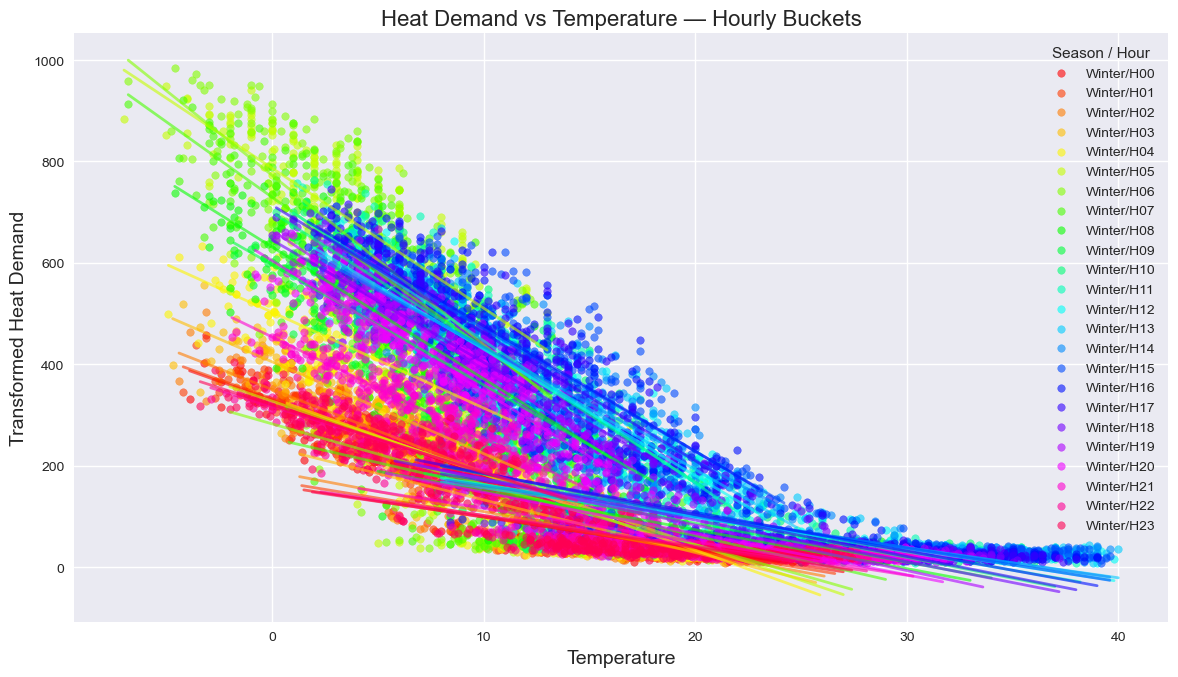

Correlation by season and hour:


Hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Season,,,,,,,,,,,,,,,,,,,,,,,,
Non-Winter,-0.77,-0.77,-0.75,-0.74,-0.71,-0.68,-0.69,-0.67,-0.69,-0.71,-0.72,-0.72,-0.71,-0.70,-0.69,-0.69,-0.71,-0.72,-0.72,-0.73,-0.72,-0.74,-0.77,-0.76
Winter,-0.85,-0.85,-0.85,-0.82,-0.79,-0.81,-0.78,-0.78,-0.81,-0.86,-0.89,-0.89,-0.88,-0.87,-0.86,-0.86,-0.89,-0.90,-0.92,-0.92,-0.92,-0.91,-0.85,-0.86


In [45]:
# === Do not edit below ===
mask = (
    (heat_df['ds'] <= pd.Timestamp('2024-06-01')) 
    & (heat_df['unique_id'] == id)
)
heat_train_id_df = heat_df[mask].copy()
mask = (
    (aux_df['ds'] <= pd.Timestamp('2024-06-01')) 
    & (aux_df['unique_id'] == id)
)
aux_train_id_df = aux_df[mask].copy()

corr_df = scatter_temp_vs_target_hourly(
    target_df=heat_train_id_df,
    aux_df=aux_train_id_df,
    date_range=pd.date_range(start='2022-05-01', end='2024-05-01', freq='h'),
    interactive=interactive
)

# Display the correlation dataframe
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Correlation by season and hour:")
    display(
        corr_df.style
        .background_gradient(cmap='Blues', axis=None, gmap=corr_df.abs(), vmax=1.0, vmin=0.0)  # Add a blue gradient
        .format(precision=2)
        .set_caption("Correlation between Temperature and Heat Demand by Season and Hour")
    )


The figure reveals a distinct difference in the temperature-demand relationship between winter and non-winter, underscoring the importance of explicitly accounting for this seasonal separation. This finding aligns with intuition, given that the target variable reflects heat demand. 

Additionally, in winter, the slope of the regression line varies noticeably by hour, indicating that daily seasonality is not driven solely by temperature. This again is expected, as human behavior plays a major role in shaping daily heating patterns. However, this complexity in daily seasonality will be addressed later by the SARIMAX residual component of the model, so for now we focus on the winter/non-winter separation only.

A closer look at the target series pointed to the need for a dynamic treatment of seasonality. As already noted with the MSTL results, the transition from warm to cold regimes (and back) does not occur on fixed calendar dates; it is at least partly **temperature-driven**. Rather than imposing a fixed "winter" window, we detect the cold season adaptively from recent temperatures. Concretely, a timestamp is labeled as belonging to the *cold semester* if the **4-day trailing mean temperature** falls below a **series-specific threshold**. We tune this threshold per time series, yielding a more responsive, data-driven delineation of seasonal behavior.

## Data preparation

The `SARIMAXPipeline.prepare_data` method provides a flexible framework for configuring exogenous variables, making it easy to experiment with and compare different modeling strategies. The supported exogenous inputs fall into two primary categories:

* **Climate-based variables**, sourced from the `aux_df` dataset (e.g., temperature).
* **Seasonal Fourier terms**, used to capture periodic patterns such as daily or weekly seasonality.

The table below summarizes all available options for preparing these exogenous features, which constitute the majority of parameters within the `SARIMAXConfig`.

> **Basic Configuration**
>
> * **`with_exog`**: Toggles the inclusion of exogenous (i.e. climate-based) variables.
> * **`exog_vars`**: List of column names from `aux_df` to use as exogenous inputs (e.g., `['temperature', 'dew_point']`). If `with_exog=True`, `temperature` **must** be included, as it is used to distinguish
between cold and warm seasonal regimes.
>
>**Transformations of Temperature**
>
>* **`temp_transform`**: Enables a piecewise-sigmoid transformation for temperature.
>* **`threshold`, `lower_asymptote`, `upper_asymptote`, `k`, `k_right`**: Parameters for the piecewise-sigmoid function, used to model saturation or diminishing returns in temperature effects.
>
>**Cold vs. Non-Cold Period Handling**
>
>* **Automatic cold period detection**: A point is labeled “cold” if the 4-day moving average temperature falls below the defined `threshold`.
>* **`is_cold`**: A derived binary indicator used to distinguish cold and non-cold periods.
>* **`k_week_only_when_cold`**: If `True`, weekly Fourier terms are only applied during cold periods, based on the `is_cold` flag.
>
>**Fourier-Based Seasonality**
>
>* **`k_week`**: Number of Fourier terms for modeling **weekly** seasonality (168-hour cycles).
>* **`k_day`**: Number of Fourier terms for modeling **daily** seasonality (24-hour cycles) (typically, we set `k_day = 0` and allow the SARIMA residuals to capture daily seasonal effects).
>
>**Lagged and Aggregated Features**
>
>* **`drop_hourly_exog`**: If `True`, raw hourly features are discarded after generating lagged or aggregated versions.
>* **`lags_exog`**: List of lag offsets (e.g., `[1, 24, 48]`) to include past values of selected exogenous variables. Ignored if `drop_hourly_exog=True`.
>* **`days_averages` / `max_lag_daily_agg`**: Computes multi-day rolling averages with optional lags (e.g., 3-day mean temperature).
>* **`hours_averages` / `max_lag_hourly_agg`**: Similar to above but over shorter hourly windows (e.g., 6-hour average).
>
>**Peak Hour Splits**
>
>* **`use_is_peak`**: If enabled, both climate-based and high-frequency features are split into `*_peak` and `*_offpeak` variants based on defined peak hours.
>* **`peak_hours`**: List of hours considered peak demand times (e.g., `[6, 7]`). Defaults to per-series selections if not specified.
>
>**Cold/Warm Feature Duplication**
>
>* When `with_exog = True`, all exogenous variables and Fourier terms are duplicated into `*_cold` and `*_warm` versions based on the `is_cold` label.
>This setup allows the model to learn season-specific effects, enabling distinct feature sets for cold and warm periods.
>* **`drop_warm`**: If set to `True`, all climate-related columns relative to the warm season are dropped, except for the 1-day rolling average of temperature (if this feature is enabled). This option is useful for simplifying the model, as heat demand tends to remain relatively flat during the warm season, making forecasting during this period less relevant.


The `piecewise_sigmoid` function for temperature transformation models a smooth, S-shaped curve that transitions from a lower bound to an upper bound, centered at a midpoint. Although we ultimately chose not to use it, it is briefly described here for completeness. It consists of two logistic curves joined at the midpoint `mid`, and is continuous (and optionally smooth in its first derivative) at that point.

Precisely:
$$
f(x) =
\begin{cases}
\ell + \dfrac{2(m - \ell)}{1 + e^{-k_L(x - m)}} & \text{if } x \leq m \\
u - \dfrac{2(u - m)}{1 + e^{k_R(x - m)}} & \text{if } x > m
\end{cases}
$$

where:
- $ \ell $ is the `lower_asymptote`;
- $ u $ is the `upper_asymptote`;
- $ m $ is the midpoint `mid`;
- $ k_L $ is `k_left` and controls the slope of the left sigmoid;
- $ k_R $ is `k_right` and controls the slope of the right sigmoid (optional). 

If `k_right` is not specified, it defaults to:
$$
k_R = k_L \cdot \frac{m - \ell}{u - m},
$$
ensuring the first derivative is continuous at $x = m$. 

$k_L$ and $k_R$ can be interpreted as steepness factors as:
$$
f'(m^-) = \frac{(m - \ell) \cdot k_L}{2},  \quad f'(m^-) = \frac{(m - \ell) \cdot k_L}{2} 
$$

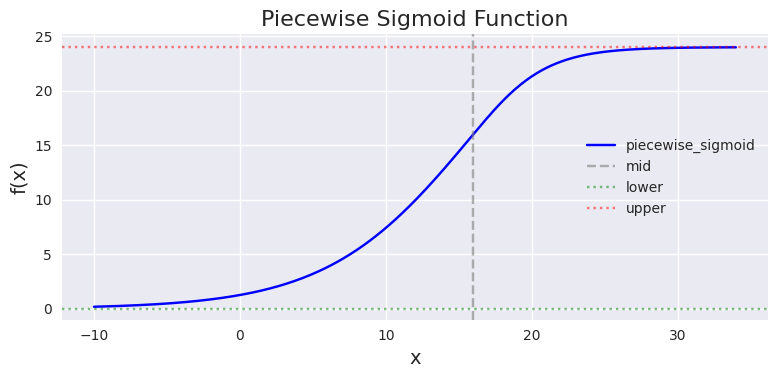

In [7]:
# === Do not edit below ===
def piecewise_sigmoid(x, mid, lower, upper, k_left=0.5, k_right=None):
    if not (lower < mid < upper):
        raise ValueError("Must satisfy: lower < mid < upper")
    
    x = np.asarray(x)

    if k_right is None:
        k_right = k_left * (mid - lower) / (upper - mid)

    left_piece = lower + 2*(mid - lower) / (1 + np.exp(-k_left * (x - mid)))
    right_piece = upper - 2*(upper - mid) / (1 + np.exp(k_right * (x - mid)))
    
    result = np.where(x <= mid, left_piece, right_piece)
    return result.item() if result.ndim == 0 else result


# --- Visualization ---
def plot_piecewise_sigmoid(mid=16, lower=0, upper=24, k_left=0.2, k_right=None):
    x_vals = np.linspace(lower - 10, upper + 10, 500)
    y_vals = piecewise_sigmoid(x_vals, mid=mid, lower=lower, upper=upper, k_left=k_left, k_right=k_right)

    plt.figure(figsize=(8, 4))
    plt.plot(x_vals, y_vals, label='piecewise_sigmoid', color='blue')
    plt.axvline(mid, color='gray', linestyle='--', alpha=0.6, label='mid')
    plt.axhline(lower, color='green', linestyle=':', alpha=0.5, label='lower')
    plt.axhline(upper, color='red', linestyle=':', alpha=0.5, label='upper')
    plt.title("Piecewise Sigmoid Function")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Try the default parameters ---
plot_piecewise_sigmoid()


The `SARIMAXPipeline.prepare_data` method also supports transforming the target variable (`y`). This can help stabilize variance and improve model performance.

> **Target Transformation Options**
>
> * **`transform`**: Specifies the transformation applied to the target variable. Options include:
>   - `"none"` or `None`: No transformation.
>   - `"log"` or `"arcsinh"`: Standard transformations for stabilizing variance.
>   - `"boxcox"`: Applies the Box-Cox transformation with λ estimated from the full training target series.
>   - `"boxcox_winter"`: Box-Cox transformation with λ estimated only from winter periods (typically mid-November to March).
>   - `"boxcox_cold"`: Box-Cox transformation with λ estimated from observations labeled as cold (`is_cold=True`).
>
> * **`lam_method`**: Specifies the method for estimating the Box-Cox λ parameter. Options:
>   - `"loglik"`: Maximum likelihood estimation.
>   - `"guerrero"`: Minimizes the coefficient of variation across groups.
>
> * **`is_winter`**: Optional custom function for defining "winter" periods used in the `boxcox_winter` setting.

## Fine tuning

### Choosing an appropriate threshold

A first, crucial parameter to choose is the `threshold` parameter (for seasonal separation, explained above). To choose it, we perform a simple linear regression, regressing the target variable with the temperature with cold/warm seasonal separation (i.e., only three variables: `temperature_cold`, `temperature_warm` and the binary `is_cold`), and see which threshold works best.

To evaluate the model's goodness of fit, we use four key metrics:

- **Adjusted $R^2$**: Measures the proportion of variance explained by the model, adjusted for the number of predictors (of course, at this stage we could avoid correcting for model complexity).

- **AICc (Corrected Akaike Information Criterion)**: A likelihood-based metric that balances model fit and complexity. The corrected version (AICc) is particularly useful for small sample sizes, helping to prevent overfitting by penalizing excessive parameters.

- **MAE "at-peak"**: Mean Absolute Error computed only on high-demand period; specifically, when heat demand exceeds 100 kWh. This focuses the evaluation on the most critical periods for forecasting accuracy.

- **Underfit Score**: Defined as the positive part of the Mean Error during peak periods $\max(0, y_t - \hat{y}_t)$. This metric highlights instances where the model significantly underestimates demand, helping to monitor underforecasting in high-demand scenarios.

In [ ]:
# Pick an id and a candidate threshold 
id = 'F1'
threshold = 13.5 # Example threshold

# === Do not edit below ===
# Initialize configuration for the desired data preparation
sconfig = SARIMAXConfig(
    with_exog=True,
    exog_vars=['temperature'],
    threshold=threshold,  
    transform='none'
)

# Create the SARIMAX pipeline with the specified configuration and generate the data
mask = (
    (heat_df['ds'] <= pd.Timestamp('2024-06-01')) 
    & (heat_df['unique_id'] == id)
)
heat_train_id_df = heat_df[mask].copy()
mask = (
    (aux_df['ds'] <= pd.Timestamp('2024-06-01')) 
    & (aux_df['unique_id'] == id)
)
aux_train_id_df = aux_df[mask].copy()
spipeline = SARIMAXPipeline(
    target_df=heat_train_id_df,
    aux_df=aux_train_id_df,
    config=sconfig,
)
spipeline.prepare_data()
prepared_data = spipeline.prepared_data

spipeline.describe_prepared_data()
    

10-06 20:15:39 | INFO | heat_forecast.pipeline.sarimax | Prepared data description:
Unique id: F1
Using target transform: none
Using a temperature transform?: false
data:
    shape: (43128, 6)
    columns:
        basic:
        - unique_id
        - ds
        - y
        climate-based:
        - temperature_cold
        - temperature_warm
        - is_cold
        fourier: []
    start_date: '2019-07-01 00:00:00'
    end_date: '2024-05-31 23:00:00'



10-06 20:15:42 | INFO | root | Results for threshold 13.5 and unique_id F1:
10-06 20:15:42 | INFO | root | > Adjusted R^2 score  : 0.792
10-06 20:15:42 | INFO | root | > AICc score          : 396857.695
10-06 20:15:42 | INFO | root | > MAE at-peak score   : 69.720
10-06 20:15:42 | INFO | root | > Underfit score      : 76.517


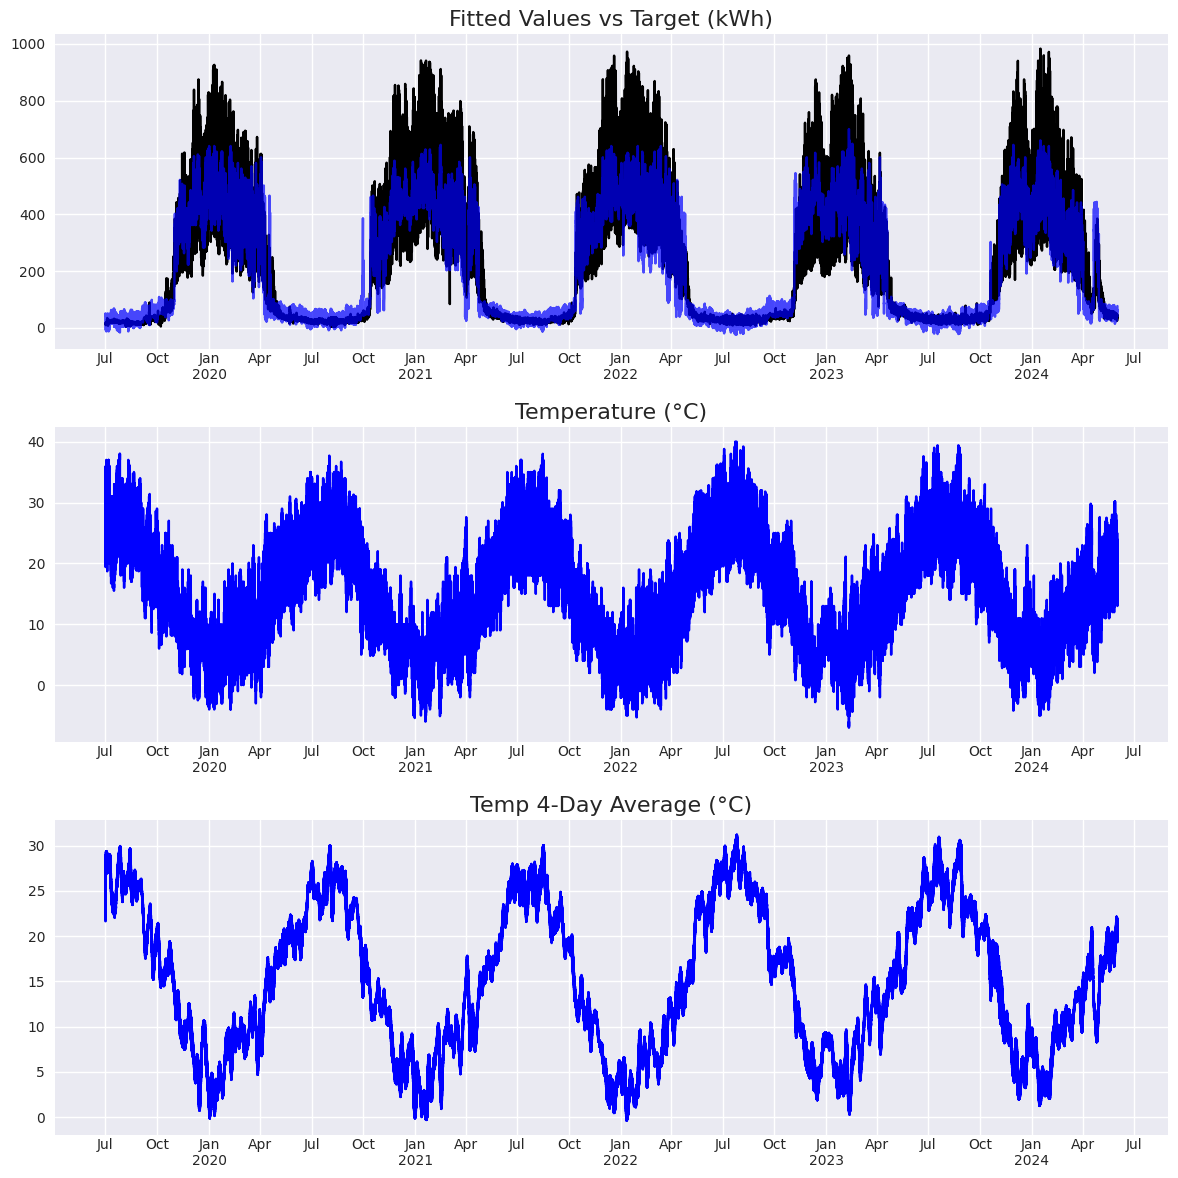

In [9]:
# Do you want to overlay warm data as red vertical lines?
highlight_warm_data = False

# === Do not edit below ===
# Fit model
mf = MLForecast(models=LinearRegression(), freq="h")
mf.fit(prepared_data, fitted=True, static_features=[])

# Get fitted values and calculate evaluation metrics
fitted_values = mf.forecast_fitted_values()
insample_forecasts = fitted_values['LinearRegression']
insample_y = prepared_data['y']

T = len(insample_y)
K_par = len(mf.models_["LinearRegression"].coef_) # Number of parameters in the linear model

logging.info(f"Results for threshold {threshold} and unique_id {id}:")
logging.info(f"> Adjusted R^2 score  : {adj_r2_score(insample_y, insample_forecasts, T, K_par):.3f}")
logging.info(f"> AICc score          : {aicc_score(insample_y, insample_forecasts, T, K_par):.3f}")
logging.info(f"> MAE at-peak score   : {mae_over_thr_score(insample_y, insample_forecasts, y_th=17):.3f}")
logging.info(f"> Underfit score      : {underforecast_over_th_score(insample_y, insample_forecasts, y_th=17):.3f}")

# plot the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.flatten()

axes[0].plot(prepared_data['ds'], insample_y, label='Transformed Target', color='black', alpha=1.0)
axes[0].plot(fitted_values['ds'], insample_forecasts, label='Fitted Values', color='blue', alpha=0.7)
axes[0].set_title('Fitted Values vs Target (kWh)')

filtered_aux_train_df = aux_df.loc[
    aux_df['ds'].isin(prepared_data['ds']), 
    ['ds', 'unique_id', 'temperature']
]
filtered_aux_train_df.sort_values(by='ds', inplace=True)

axes[1].plot(filtered_aux_train_df['ds'], filtered_aux_train_df['temperature'], label='Temperature', color='blue', alpha=1.)
axes[1].set_title('Temperature (°C)')

filtered_aux_train_df['temp_fewdays_avg'] = (
    filtered_aux_train_df
    .groupby('unique_id')['temperature']
    .rolling(window=24*4, min_periods=1)  
    .mean()
    .reset_index(0, drop=True)
)

axes[2].plot(filtered_aux_train_df['ds'], filtered_aux_train_df['temp_fewdays_avg'], label='Temp 4-Day Avg', color='blue', alpha=1.)
axes[2].set_title('Temp 4-Day Average (°C)')

# Overlay missing timestamps as red vertical lines
if highlight_warm_data:
    cold_df = prepared_data[prepared_data['is_cold'] == 1].copy()
    all = pd.date_range(start=prepared_data['ds'].min(), end=prepared_data['ds'].max(), freq='h')
    actual = pd.Series(1, index=cold_df['ds'])
    missing = all.difference(actual.index)
    axes[0].vlines(
        x=missing,
        ymin=cold_df['y'].min(),  
        ymax=cold_df['y'].max(), 
        color='red',
        linestyle='--',
        alpha=0.5,
        linewidth=0.5
    )

configure_time_axes(axes, prepared_data['ds'])

fig.tight_layout()

Based on a manual evaluation of several thresholds, we chose suitable thresholds for each series, as shown below:

In [10]:
best_thresholds = {
    'F1': 13.5,
    'F2': 13.8,
    'F3': 13.8,
    'F4': 12.8,
    'F5': 13.8,
}

### Choosing temperature and target transformations

After selecting an appropriate threshold, the second step involves choosing suitable transformations for both the target and the temperature variables. We adopt the following strategy:

* **No transformation of temperature**: We opt to use raw temperature values, as the time series do not show evidence of saturation effects on the cold side (i.e., there is no visible plateau in heat demand at very low temperatures). Additionally, potential saturation effects on the warm side are already accounted for by the seasonal (cold/warm) separation in the modeling pipeline.

* **Box-Cox transform of the target (`boxcold_cold`)**: We apply a Box–Cox transformation to stabilize variance, with parameter lambda tuned to the extended-winter (cold-regime) segment of the series. Because the weekly seasonal regressors (Fourier terms) are estimated separately for cold vs. warm regimes but are **fixed within each regime**, we need daily/weekly seasonality to have roughly constant amplitude inside those windows, especially in the cold period. Emphasizing the cold regime in the transform reduces heteroscedasticity there, making the seasonal pattern more stable and improving fit.


### Choosing climate-based features and SARIMA parameters

Performing an exhaustive grid search over SARIMA parameters is impractical due to prohibitively long training times. Instead, we adopt a more efficient, staged approach:

- **Step 1: Initial Model Selection**  
  Begin by fixing a promising SARIMA structure for the residuals based on early experimentation. In our case, preliminary tests consistently pointed to:  
  $$
  \text{SARIMA}(p,d,q)\times(P,D,Q)_{s} = \text{SARIMA}(1,0,0)\times(1,1,1)_{24}
  $$  
  This structure was identified by first selecting simple but reasonable auxiliary regression variables, fitting a linear model, and analyzing the ACF and PACF plots of the residuals. These plots suggested a similar model, differing only by $Q = 0$. Subsequent cross-validation with minimal parameter adjustments confirmed the above configuration as a robust starting point. Additionally, running `AutoARIMA` on series F1 (with conservative starting values) repeatedly returned either the same model or slight variations, further supporting this selection.

- **Step 2: Targeted Cross-Validation**  
  Perform cross-validation over a limited set of SARIMA parameter combinations, gradually increasing model complexity to identify the best-performing configuration.

- **Step 3 (Optional): AutoARIMA Refinement**  
  Optionally, apply an AutoARIMA procedure initialized with the best parameters from Step 2 to explore nearby configurations. If improvements are found, repeat the cross-validation process.

- **Step 4 (Optional): Expand Exogenous Variables**  
  Optionally, repeat the entire process using additional exogenous variables beyond temperature to assess potential gains in predictive performance.

In practice, however, neither Step 3 nor Step 4 led to significant improvements in our results.

Below, we carry out **Step 2** of the tuning procedure described above. We consider 12 configurations of increasing complexity. For each unique ID and forecast horizon (either 1-day or 7-day ahead), every configuration was evaluated over 30 rolling windows for the day-ahead forecast and 20 windows for the week-ahead forecast, covering the extended winter period of 2023/2024. We then compared performance statistics across several error metrics (primarily MAE and RMSE) to identify the best candidate model for each ID and horizon. 

The focus on non-normalized metrics such as MAE (as opposed to normalized ones like sMAPE) is intentional: since they are sensitive to the magnitude of the target series, they naturally penalize poor forecasts more heavily during periods of high heat demand, when both the level and variability of the series are greatest. This behavior is desirable in practical applications.

In [ ]:
finetune = False  # Set to False to skip fine-tuning

# === Do not edit below ===
 # Forecast horizon in hours (1 week). We only use this forecast horizon for fine-tuning
            # because it allows as to consider less windows and since we are testing a very limited set of parameters
            # in which we study the effectiveness of different variables in explaining the target,
            # we don't expect to get meaningfully different results with shorter horizons

# Note: by default we have:
# - `tranform`='boxcox_cold';
# - `lam_method`='loglik';
# - `k_week_only_when_cold`=True;

all_params = [
    { # 0: Simplest parameters, should still work fairly well for all facilities
        'k_week': 4,
        'threshold': best_thresholds[id],
        'days_averages': [1],
        'drop_hourly_exog': True,
        'lags_exog': None,
        'use_peak_hours': False, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 1: Basic parameters, only added hourly exogenous
        'k_week': 4,
        'threshold': best_thresholds[id],
        'days_averages': [1],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 2: More Fourier terms
        'k_week': 7,
        'threshold': best_thresholds[id],
        'days_averages': [1],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False,
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 3: Added 4-day averages, separation of the raw exog using peak hours; removed some fourier terms
        'k_week': 5,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 4: Added 1 lag of temperature
        'k_week': 5,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 5: More lags of tempearture
        'k_week': 5,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1, 2, 3],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 6: More fourier terms, heaviest configuration
        'k_week': 7,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1, 2, 3],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 7: Back to the 5th configuration (SARIMAX_4), but with more fourier and without peak hours ad lag exog
        'k_week': 7,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 8: Added peak hours separation
        'k_week': 7,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 9: Added a lag of temperature, removed peak hours
        'k_week': 7,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': False,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 10: Added peak hours
        'k_week': 7,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    { # 11: Added an additional year of data in the training set
        'k_week': 7,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24 * 2,
    },
    { # 12: Back to SARIMAX_10, but with more fourier terms
        'k_week': 9,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
]

if finetune:
    # ------------- Choose parameters for cross-validation -------------
    # For get_cv_params:
    step_size = 24  # 24h step size
    max_n_fits = 15 # upper bound on number of fits
    h = 168         # forecast horizon in hours (1 week)
    start_test_cv = pd.to_datetime('2023-11-01')
    end_test_cv = pd.to_datetime('2024-04-01')

    metadata = {f'params_set_{i}': all_params[i] for i in range(len(all_params))}
    metadata['for_get_cv_params'] = {
        'step_size': step_size,
        'max_n_fits': max_n_fits,
        'forecast_horizon': h,
        'start_test_cv': str(start_test_cv),
        'end_test_cv': str(end_test_cv),
    }

    # ------------- Create directory for fine-tuning results -------------
    timestamp = datetime.now(ZoneInfo("Europe/Rome")).strftime("%Y%m%dT%H%M%S")
    run_id = f"{id}_finetuning_sarimax_{timestamp}"
    path = BASE_DIR / "results" / "finetuning" / "sarimax" / run_id
    metadata['run_id'] = run_id

    try:
        path.mkdir(parents=True, exist_ok=False)
        logging.info(f"Created directory for fine-tuning results: {path.relative_to(BASE_DIR)}")

        # ------------- Set windows with get_cv_params -------------  
        cv_params = get_cv_params_v2(
            start_test_cv=start_test_cv,
            end_test_cv=end_test_cv,
            step_size=step_size,
            max_n_fits=max_n_fits,
            horizon_hours=h,
        )
        metadata['cv_params'] = cv_params
        end_test_cv = cv_params['end_test_actual']
        n_windows = cv_params['n_windows']
        test_hours = cv_params['test_hours']
        refit = cv_params['refit']
        n_fits = cv_params['n_fits']

        # ------------- Run CV once with the naive model for comparison -------------
        naive_model = SeasonalNaive(season_length=24, alias='Naive24h')
        sf = StatsForecast(models=[naive_model], freq='h')
        heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
        full_df = heat_id_df[heat_id_df['ds'] <= end_test_cv]  # Use all data up to the end of the last forecast horizon
        t0 = pd.Timestamp.now()
        cv_naive = sf.cross_validation(
            h=h,
            df=full_df,
            n_windows=n_windows,
            step_size=step_size,  
            test_size=test_hours,  
            input_size=None,  
        )
        t1 = pd.Timestamp.now()
        elapsed = (t1 - t0).total_seconds()
        params_placeholder = {key: None for key in all_params[0].keys()}
        params_except_sarima = {k:v for k,v in params_placeholder.items() if k != 'sarima_kwargs'}
        record = {
            'name': 'Naive24h',
            'avg_elapsed_per_fit_sec': elapsed/n_windows,  
            **params_except_sarima,  # Don't need to retain the SARIMA parameters for records
        }

        # store results and corresponding params / name of the model / elapsed time
        records = [record]  
        cv_frames = [cv_naive]

        # ------------- Run grid search for MSTL model -------------
        aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
        t_start_cv = pd.Timestamp.now()
        for i, params in enumerate(tqdm(all_params, desc="Grid search", leave=True)):

            sconfig = SARIMAXConfig(**params)
            spipeline = SARIMAXPipeline(
                target_df=heat_id_df,
                aux_df=aux_id_df,
                config=sconfig,
            )
            t0 = pd.Timestamp.now()
            cv_sarimax = spipeline.cross_validation(
                h=h,                   # Forecast horizon in hours
                test_size=test_hours,  # Test size in hours
                end_test=end_test_cv,  # End of the test period
                step_size=step_size,   # Step size in hours
                refit=refit,           # Whether to refit the model at each window
                verbose=False,
                alias=f'SARIMAX_{i}',  # Alias for the model
                # NB: the input size is not used here, it should be specified in the SARIMAXConfig
            )
            t1 = pd.Timestamp.now()
            elapsed = (t1 - t0).total_seconds()
            cv_sarimax.drop(columns=['y'], inplace=True)
            cv_frames.append(cv_sarimax)

            params_except_sarima = {k:v for k,v in params.items() if k != 'sarima_kwargs'}
            record = {
                'name': f'SARIMAX_{i}',  
                'avg_elapsed_per_fit_sec': elapsed/n_fits,
                **params_except_sarima,  
            }
            records.append(record)

        # ------------- Combine all cross-validation results into a single DataFrame -------------
        key_cols = ["unique_id", "ds", "cutoff"]
        cv_results_df = reduce(
            lambda left, right: pd.merge(left, right, on=key_cols, how="outer", copy=False),
            cv_frames            
        )
        records_df = pd.DataFrame(records)
        results = (records_df, cv_results_df)

        t_end_cv = pd.Timestamp.now()
        elapsed_cv = str(t_end_cv - t_start_cv)
        metadata['total_elapsed_time'] = elapsed_cv

        # ------------- Final save -------------
        records_df.to_parquet(path / "records.parquet", compression="snappy")
        cv_results_df.to_parquet(path / "cv_results.parquet", compression="snappy")

        metadata_path = path / 'metadata.yaml'
        with open(metadata_path, 'w') as f:
            safe_dump_yaml(
                metadata,
                f,
                indent=4, # indentation for nested structures
            )

        logging.info("✓ All artifacts saved successfully, fine-tuning completed.")

    except KeyboardInterrupt:
        logging.warning("✗ Interrupted; cleaning up.")
        remove_tree(path, require_within=BASE_DIR)
        logging.info("✓ Removed %s", Path(path).relative_to(BASE_DIR) if BASE_DIR in Path(path).resolve().parents else path)
        raise
    except Exception:
        logging.exception("✗ Error during test for id=%s; cleaning up.", id)
        remove_tree(path, require_within=BASE_DIR)
        logging.info("✓ Removed %s", Path(path).relative_to(BASE_DIR) if BASE_DIR in Path(path).resolve().parents else path)
        raise

Load a completed study from `<base>/results/finetuning/sarimax` and compute the metrics:

In [34]:
# Optional: pick a run_id to analyze 
run_id = 'F5_finetuning_sarimax_20250828T120959'  

# === Do not edit below ===
# --- Load the metadata for the run_id ---
path = BASE_DIR / "results" / "finetuning" / "sarimax" / run_id
records_df = pd.read_parquet(path / "records.parquet")
cv_results_df = pd.read_parquet(path / "cv_results.parquet")

real_cutoffs = ['2023-10-31T23:00:00', '2023-11-10T23:00:00', '2023-11-20T23:00:00', '2023-11-30T23:00:00', '2023-12-10T23:00:00', \
                '2023-12-20T23:00:00', '2023-12-30T23:00:00', '2024-01-09T23:00:00', '2024-01-19T23:00:00', '2024-01-29T23:00:00', \
                '2024-02-08T23:00:00', '2024-02-18T23:00:00', '2024-02-28T23:00:00', '2024-03-09T23:00:00', '2024-03-19T23:00:00']
real_cutoffs = pd.to_datetime(real_cutoffs)
cv_results_df = cv_results_df[cv_results_df['cutoff'].isin(real_cutoffs)].copy()

# --- Evaluate results ---
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message="DataFrame is highly fragmented",
        category=pd.errors.PerformanceWarning,
    )
    summary, combined_results = custom_evaluate_cv(
        cv_df=cv_results_df,
        metrics=['mae', 'rmse', 'mase', 'nmae'],  # List of metrics to compute
        target_df=heat_df,  
    )

View statistical summaries of evaluation metrics across windows:

In [31]:
# --- Display with optional sorting ---
wide_summary = display_cv_summary(
    summary,
    sort_metric='mae',  
    sort_stat='mean',   # Sort by the mean of the metric
    ascending=True,     # Sort by ascending order of the metric
    by_panel=True,
    show_row_numbers=True
)

In [25]:
# --- Display the records of the first n models ---
n = 50     # how many?  

# === Do not edit below ===
# Select the first n models based on the sorted summary snd the corresponding records
s = wide_summary.reset_index()    
models_chosen = s.iloc[:n, s.columns.get_loc("model")].to_numpy().reshape(-1).tolist()
model_order = {model: i for i, model in enumerate(models_chosen)}
filtered_df = records_df.loc[records_df['name'].isin(models_chosen), :].copy()
filtered_df['order'] = filtered_df['name'].map(model_order)
ordered_df = filtered_df.sort_values('order').drop('order', axis=1).reset_index(drop=True)

# Display the ordered DataFrame with all rows and columns
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(ordered_df)

,name,avg_elapsed_per_fit_sec,k_week,threshold,days_averages,drop_hourly_exog,lags_exog,use_peak_hours,input_size
0,SARIMAX_11,138.033,7.000,13.800,"[1, 4]",False,[1],True,17520.000
1,SARIMAX_7,55.409,7.000,13.800,"[1, 4]",False,None,False,8760.000
2,SARIMAX_12,73.895,9.000,13.800,"[1, 4]",False,[1],True,8760.000
3,SARIMAX_9,57.599,7.000,13.800,"[1, 4]",False,[1],False,8760.000
4,SARIMAX_10,64.057,7.000,13.800,"[1, 4]",False,[1],True,8760.000
5,SARIMAX_8,59.837,7.000,13.800,"[1, 4]",False,None,True,8760.000
6,SARIMAX_6,73.299,7.000,13.800,"[1, 4]",False,"[1, 2, 3]",True,8760.000
7,SARIMAX_3,51.356,5.000,13.800,"[1, 4]",False,None,True,8760.000
8,SARIMAX_4,55.350,5.000,13.800,"[1, 4]",False,[1],True,8760.000
9,SARIMAX_5,64.301,5.000,13.800,"[1, 4]",False,"[1, 2, 3]",True,8760.000


View statistic of differences:

In [178]:
# --- Choose how many models to display, or pick them individually ---
n_models = 20  # how many? (from the top of the sorted summary) 
models = None  # or specify a list of model names, e.g., ['SARIMAX_0', 'SARIMAX_3', 'Naive24h']

baseline_model = 'SARIMAX_9'

# === Do not edit this box ===
def top_n_models(wide_summary, n, baseline): 
    all_models = list(wide_summary.index.get_level_values('model').unique())
    top_models = all_models[:n_models]
    return top_models

def ensure_baseline_included(models, baseline_model):
    all_models = list(wide_summary.index.get_level_values('model').unique())
    if baseline_model not in all_models:
        raise ValueError(f"Baseline model '{baseline_model}' not found in the results.")
    if baseline_model not in models:
        models.append(baseline_model)

def filter_combined(combined_results, models):
    cols = ['unique_id', 'metric', 'cutoff'] + models
    filtered_combined = combined_results.loc[:, cols].copy()
    return filtered_combined

if models is None:
    models = top_n_models(wide_summary, n_models, baseline_model)
ensure_baseline_included(models, baseline_model)
filtered_combined = filter_combined(combined_results, models)

summary_ld, combined_ld = compute_loss_diff_stats(
    combined_results=filtered_combined,
    baseline_model=baseline_model
)
# ============================

# --- Display the results ---
wide_summary_ld = display_cv_summary(
    summary_ld,
    sort_metric='mae',  
    sort_stat='mean',   # Sort by the mean of the metric
    ascending=True,     # Sort by ascending order of the metric
    by_panel=True,
    show_row_numbers=True
)

In [ ]:
# --- Choose how many models to display, or pick them individually ---
n_models = 3  # how many? (from the top of the sorted summary) 
models = ['SARIMAX_12']  # or specify a list of model names, e.g., ['SARIMAX_0', 'SARIMAX_3', 'Naive24h']

baseline_model = 'SARIMAX_9'

# === Do not edit this box ===
if models is None:
    models = top_n_models(wide_summary, n_models, baseline_model)
ensure_baseline_included(models, baseline_model)
filtered_combined = filter_combined(combined_results, models)
summary_ld, combined_ld = compute_loss_diff_stats(
    combined_results=filtered_combined,
    baseline_model=baseline_model
)
models_diff = [f"LD-{m}" for m in models if m != baseline_model]
# ============================

# --- Plot the original models ---
fig = plotly_cv_metric_by_cutoff(
    combined_results=filtered_combined,
    metric="mae",
    models=models,         
    width=1000,          
)
display_scrollable(fig)  

# --- Plot differences ---
fig = plotly_cv_metric_by_cutoff(
    combined_results=combined_ld,
    metric="mae",
    models=models_diff,         
    width=1000, 
    title_suffix=f"Normalized by {baseline_model}"          
)
display_scrollable(fig)  

interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_results_df,
    add_context=True,
    figsize=(11, 6)
)

### Final optimal parameters

* **Series F1**:
The leading SARIMAX configurations deliver almost indistinguishable accuracy, indicating that further hyperparameter tuning would yield minimal benefit. Given its strong performance and lower computational cost (~57 s vs. ~73 s), `SARIMAX_9` is selected as the preferred model. Differences in MAE across models are negligible relative to the scale of the series (in the hundreds), confirming that observed variations are statistically and practically negligible. Therefore, we retain **`SARIMAX_9`** as our final model for F1.

* **Series F2:**
`SARIMAX_11` marginally outperforms the other configurations, with an average MAE approximately 1 point lower than the second-best model (`SARIMAX_6`) and an NMAE reduction of about 0.4 percentage points. The difference appears consistent across folds, as the fold-wise loss differences relative to `SARIMAX_6` yield a mean MAE of -1.15 ± 1.67, and `SARIMAX_6` surpasses clearly `SARIMAX_11` in only 1 out of 15 validation windows. This pattern suggests a genuine, albeit small, improvement in predictive accuracy. However, the magnitude of this improvement is negligible in relative terms and therefore it does not justify the nearly doubled computational time required by `SARIMAX_11` (141 s vs. 77 s). Consequently, we retain **`SARIMAX_6`** as the final model, as it provides a more efficient and practically equivalent alternative.

* **Series F3**: 
The leading SARIMAX configurations again exhibit very similar predictive performance. We select `SARIMAX_7`, which is the fastest among the top performers while maintaining high accuracy. The only model offering a noticeable additional time saving is `SARIMAX_1` (40 s vs. 55 s), but it performs consistently worse: the fold-wise loss differences (`SARIMAX_7` - `SARIMAX_1`) yield a mean MAE of -6.17 ± 5.90, with `SARIMAX_1` outperforming `SARIMAX_7` in only two folds: the first and last, both near the warm season and thus less representative of typical conditions. Considering that 55 seconds is already a modest computation time relative to more complex deep learning models, we retain **`SARIMAX_7`** as the preferred specification. In practical scenarios where minimal training time is a priority, `SARIMAX_1` could serve as a slightly less accurate but faster alternative.

* **Series F4:**
All configurations yield nearly identical results, indicating that the inclusion of additional or more complex covariates provides little incremental predictive value. This suggests limited linear dependence between the target and the exogenous variables. We select **`SARIMAX_3`**, which is among the most accurate models and also one of the fastest to train. Although `SARIMAX_4` appeared slightly faster, this difference may be due to external runtime variability, as `SARIMAX_3` relies on fewer exogenous variables.

* **Series F5**: 
`SARIMAX_12` achieves the lowest mean MAE among all configurations. The next most accurate model that offers a notable computational advantage (~25% faster) is **`SARIMAX_9`**. However, `SARIMAX_12` performs consistently better, yielding lower MAE values across all folds. The mean fold-wise difference (`SARIMAX_12` - `SARIMAX_9`) is -1.26 with a standard deviation of 1.13, indicating that the improvement is small but systematic and slightly exceeds the expected variability. Consequently, we select **`SARIMAX_12`** as the preferred model.

In [ ]:
save = False  # Set to False to skip saving the parameters

# === Do not edit below ===
sarimax_optimal_params = {
    'F1': { # SARIMAX_9 from run_id = 'F1_finetuning_sarimax_20250827T115146' 
        'k_week': 7,
        'threshold': best_thresholds['F1'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    'F2': { # SARIMAX_6 from run_id = 'F2_finetuning_sarimax_20250827T115253'
        'k_week': 7,
        'threshold': best_thresholds['F2'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1, 2, 3],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    }, 
    'F3': { # SARIMAX_7 from run_id = 'F3_finetuning_sarimax_20250827T153215'
        'k_week': 7,
        'threshold': best_thresholds['F3'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    'F4': { # SARIMAX_3 from run_id = 'F4_finetuning_sarimax_20250827T153251'
        'k_week': 5,
        'threshold': best_thresholds['F4'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    'F5': { # SARIMAX_12 from run_id = 'F5_finetuning_sarimax_20250828T120959'
        'k_week': 9,
        'threshold': best_thresholds['F5'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
}

if save:
    params_path = BASE_DIR / "models" / "sarimax_optimal_params.yaml"
    with open(params_path, 'w') as f:
        safe_dump_yaml(
            sarimax_optimal_params,
            f,
            indent=4,                    # indentation for nested structures
        )
    logging.info("✓ Optimal parameters saved successfully.")

### AutoARIMA additional model selection

In this section, we apply Nixtla’s AutoARIMA routine to identify the model that minimizes the AICc criterion, using the optimal features determined in the previous tuning step. We then perform cross-validation with the newly selected model on the same windows as before, allowing a direct comparison of its predictive accuracy against the previously tuned model.

In [ ]:
# Pick an id 
id = 'F1'

# Set to True to run the search for optimal SARIMA parameters
do_search = False

# === Do not edit this box ===
if do_search:
    # Initialize configuration
    optimal_params = sarimax_optimal_params[id]
    sconfig = SARIMAXConfig(**optimal_params)

    # Construct datasets
    mask = (heat_df['unique_id'] == id)
    heat_train_id_df = heat_df[mask].copy()
    mask = (aux_df['unique_id'] == id)
    aux_train_id_df = aux_df[mask].copy()

    # Construct the SARIMAX pipeline using the best config
    spipeline = SARIMAXPipeline(
        target_df=heat_train_id_df,
        aux_df=aux_train_id_df,
        config=sconfig,
    )
    spipeline.prepare_data()
    spipeline.describe_prepared_data()

    # Create a directory for saving results
    timestamp = datetime.now(ZoneInfo("Europe/Rome")).strftime("%Y%m%dT%H%M%S")
    run_id = f"{id}_search_opt_sarimax_{timestamp}"
    path = BASE_DIR / "results" / "finetuning" / "sarimax" / run_id
    
    try:
        path.mkdir(parents=True, exist_ok=False)
        logging.info(f"Created directory for search results: {path.relative_to(BASE_DIR)}")

        t0 = pd.Timestamp.now()
        end_train = pd.Timestamp('2023-06-30T23:00:00')
        result = spipeline.search_optimal_sarima_model(end_train=end_train, n_models=94)
        t1 = pd.Timestamp.now()
        elapsed = (t1 - t0).total_seconds()
        
        result_path = path / 'result.yaml'
        with open(result_path, 'w') as f:
            safe_dump_yaml(
                result,
                f,
                indent=4, 
            )

        metadata = {
            'params': optimal_params,
            'end_train': end_train,
            'run_id': run_id,
            'avg_elapsed_sec': elapsed
        }
        metadata_path = path / 'metadata.yaml'
        with open(metadata_path, 'w') as f:
            safe_dump_yaml(
                metadata,
                f,
                indent=4, 
            )

        logging.info("✓ All artifacts saved successfully.")

    except KeyboardInterrupt:
        logging.warning("✗ Interrupted; cleaning up.")
        remove_tree(path, require_within=BASE_DIR)
        logging.info("✓ Removed %s", Path(path).relative_to(BASE_DIR) if BASE_DIR in Path(path).resolve().parents else path)
        raise
    except Exception:
        logging.exception("✗ Error during test for id=%s; cleaning up.", id)
        remove_tree(path, require_within=BASE_DIR)
        logging.info("✓ Removed %s", Path(path).relative_to(BASE_DIR) if BASE_DIR in Path(path).resolve().parents else path)
        raise


Perform cross-validation with the new models:

In [29]:
# Pick a unique id
id = "F5"
do_cv = True

best_sarima = {
    'F1': {'order': (5, 0, 0), 'season_length': 24, 'seasonal_order': (1, 1, 1)},
    'F2': {'order': (1, 0, 5), 'season_length': 24, 'seasonal_order': (2, 1, 2)},
    'F3': {'order': (1, 1, 2), 'season_length': 24, 'seasonal_order': (0, 0, 2)},
    'F4': {'order': (1, 0, 0), 'season_length': 24, 'seasonal_order': (1, 1, 1)},
    'F5': {'order': (5, 1, 1), 'season_length': 24, 'seasonal_order': (2, 0, 0)},
}

if do_cv:
    # ------------- Choose parameters for cross-validation -------------
    # For get_cv_params:
    n_windows = 15  
    h = 168        
    start_test_cv = pd.to_datetime('2023-11-01')
    end_test_cv = pd.to_datetime('2024-04-01')

    # ------------- Set windows with get_cv_params -------------  
    cv_params = get_cv_params_v2(
        start_test_cv=start_test_cv,
        end_test_cv=end_test_cv,
        n_windows=n_windows,
        horizon_hours=h,
    )
    step_size = cv_params['step_size']
    end_test_cv = cv_params['end_test_actual']
    n_windows = cv_params['n_windows']
    test_hours = cv_params['test_hours']

    # ------------- Run CV loop -------------
    # Filter dataset for id
    heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
    full_df = heat_id_df[heat_id_df['ds'] <= end_test_cv]
    aux_id_df = aux_df[aux_df['unique_id'] == id].copy()

    optimal_params = sarimax_optimal_params[id]
    optimal_params['sarima_kwargs'] = best_sarima[id]

    sconfig = SARIMAXConfig(**optimal_params)
    spipeline = SARIMAXPipeline(
        target_df=heat_id_df,
        aux_df=aux_id_df,
        config=sconfig,
    )
    spipeline.prepare_data()
    t0 = pd.Timestamp.now()
    cv_sarimax_df = spipeline.cross_validation(
        h=h,                   # Forecast horizon in hours
        test_size=test_hours,  # Test size in hours
        end_test=end_test_cv,  # End of the test period
        step_size=step_size,   # Step size in hours
        verbose=True,
        alias='SARIMAX',  # Alias for the model
        # NB: the input size is not set here, as it defaults to the one specified in SARIMAXConfig
    )
    t1 = pd.Timestamp.now()
    elapsed = (t1 - t0).total_seconds()

    params_except_sarima = {k:v for k,v in optimal_params.items() if k != 'sarima_kwargs'}
    record = {
        'name': f'SARIMAX_new',  
        'avg_elapsed_per_fit_sec': elapsed/n_fits,
        **params_except_sarima,  
    }
    record_df = pd.DataFrame([record])

    # Compute evaluation metrics
    summary, combined_results = custom_evaluate_cv(
        cv_df=cv_sarimax_df,
        metrics=['mae', 'rmse', 'mase', 'nmae'],  # List of metrics to compute
        target_df=heat_df,  
    )

    # Display wide summary
    wide_summary = display_cv_summary(
        summary,
        sort_metric='mae',  
        sort_stat='mean',   # Sort by the mean of the metric
        ascending=True,     # Sort by ascending order of the metric
        by_panel=True,
        show_row_numbers=True
    )

    # Display record
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        display(record_df)

10-06 22:47:16 | INFO | heat_forecast.utils.cv_utils | CV params: 15 windows, first cutoff 2023-10-31 23:00:00, last cutoff 2024-03-19 23:00:00, step size 10d 0h, total number of fits: 15.


CV windows:   0%|          | 0/15 [00:00<?, ?it/s]

,name,avg_elapsed_per_fit_sec,k_week,threshold,days_averages,drop_hourly_exog,lags_exog,use_peak_hours,input_size
0,SARIMAX_new,56.669,9,13.800,"[1, 4]",False,[1],True,8760


### Observations

* **F1**: The newly selected SARIMA(5,0,0)(1,1,1)[24] fits the training data slightly better than the previous SARIMA(1,0,0)(1,1,1)[24], as reflected in higher log-likelihood and improved information criteria. However, predictive accuracy is virtually unchanged. This, combined with the increase in training time (69 s vs. 60 s), convinced us to retain the old model as the final one.

* **F2**: The new model achieves very similar predictive accuracy compared to the old one. The key drawback is efficiency: the new model requires nearly three times as much time per fit (206.2 s vs. 76.6 s) without any compensating accuracy gain.

* **F3**: The new model clearly overfits. Its predictive accuracy is substantially worse than the previous one (MAE: 53.56 vs. 45.08), and although the difference between means is withing one standard deviation, we also know that variance is always inflated due to the non-stationarity of the series. Moreover, the new model doesn't offer any time advantage either, therefore we retain the old one.

* **F4**: The new search converged on the same configuration as the one we had picked manually: SARIMA(1,0,0)(1,1,1)[24]. This provides reassurance about the robustness of the choice.

* **F5**: The new model is faster (50.4 s vs. 80.5 s per fit). It might yield slighlty worse results, but the difference seems statistically non-relevant, and a visual comparison of by fold metrics doesn't reveal a consistent winner. However, a visual inspection of predictions shows that the new model always underestimates the usual early morning peaks, likely due to the 0 derivative in the seasonal order. Since in the practical application of these forecasts an accurate prediction of the morning peak is important, we are willing to accept the increased computational time for this accuracy gain during peak hours. Therefore, we retained as our final model the old one.


| model new/old | id | avg elapsed per fit (sec) | MAE mean | MAE std | MASE mean | MASE std | NMAE mean | NMAE std | RMSE mean | RMSE std |
|---------------|----|----------------------|----------|---------|-----------|----------|-----------|----------|-----------|----------|
| new           | F1 | 69.0                 | 33.84    | 8.14    | 1.47      | 0.37     | 9.00%     | 3.83%    | 43.37     | 9.87     |
| old           | F1 | 60.1                 | 33.47    | 7.18    | 1.46      | 0.33     | 8.87%     | 3.58%    | 43.18     | 8.89     |
| new           | F2 | 206.2                | 32.49    | 8.32    | 1.91      | 0.48     | 10.70%    | 4.51%    | 44.22     | 11.44    |
| old           | F2 | 76.6                 | 31.39    | 7.55    | 1.85      | 0.43     | 10.25%    | 3.89%    | 42.94     | 10.16    |
| new           | F3 | 55.3                 | 53.56    | 18.44   | 1.41      | 0.49     | 12.85%    | 3.99%    | 65.88     | 20.16    |
| old           | F3 | 55.4                 | 45.08    | 14.44   | 1.19      | 0.39     | 11.16%    | 4.87%    | 56.20     | 17.42    |
| new           | F5 | 56.7                 | 51.69    | 15.46   | 1.35      | 0.43     | 23.25%    | 8.35%    | 68.74     | 19.03    |
| old           | F5 | 80.5                 | 49.79    | 20.87   | 1.30      | 0.57     | 22.57%    | 11.50%   | 64.25     | 23.92    |

## Testing

Final model testing is conducted using a cross-validation procedure focused on the cold season of 2024–2025. For the **weekly forecast horizon**, approximately **20 test windows** are used, while the **daily horizon** utilizes around **35 windows**. The number of windows for the weekly horizon is deliberately limited to minimize correlation between adjacent test periods.

The exact number of windows, as well as the start and end dates of the test period, may vary slightly between time series. In each case, the test range and number of windows are chosen to:

* start when heat demand begins to rise after the summer period and end as demand declines with the return of warmer weather;
* use a step size of 9 for weekly forecasts and 5 for daily forecasts.

In [ ]:
# --- Final parameters per facility ---
save = False  # Set to False to skip saving the parameters

sarimax_optimal_params = {
    'F1': { # SARIMAX_9 from run_id = 'F1_finetuning_sarimax_20250827T115146' 
        'k_week': 7,
        'threshold': best_thresholds['F1'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    'F2': { # SARIMAX_6 from run_id = 'F2_finetuning_sarimax_20250827T115253'
        'k_week': 7,
        'threshold': best_thresholds['F2'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1, 2, 3],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    }, 
    'F3': { # SARIMAX_7 from run_id = 'F3_finetuning_sarimax_20250827T153215'
        'k_week': 7,
        'threshold': best_thresholds['F3'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    'F4': { # SARIMAX_3 from run_id = 'F4_finetuning_sarimax_20250827T153251'
        'k_week': 5,
        'threshold': best_thresholds['F4'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
    'F5': { # SARIMAX_12 from run_id = 'F5_finetuning_sarimax_20250828T120959', with updated SARIMA orders
        'k_week': 9,
        'threshold': best_thresholds['F5'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
        'input_size': 365 * 24,
    },
}

if save:
    params_path = BASE_DIR / "models" / "sarimax_optimal_params.yaml"
    with open(params_path, 'w') as f:
        safe_dump_yaml(
            sarimax_optimal_params,
            f,
            indent=4,                    # indentation for nested structures
        )
    logging.info("✓ Optimal parameters saved successfully.")

10-06 23:52:37 | INFO | root | ✓ Optimal parameters saved successfully.


In [ ]:
do_test = True  # Set to False to skip test

# DONE:

if do_test:
    grid = list(product(['F1'], ['week']))
    for id, horizon_type in tqdm(grid, desc="Test", leave=True):

        metadata = {}

        # ------------- Create directory for test results -------------
        timestamp = datetime.now(ZoneInfo("Europe/Rome")).strftime("%Y%m%dT%H%M%S")
        run_id = f"{id}_{horizon_type}_test_sarimax_{timestamp}"
        path = BASE_DIR / "results" / "test" / "sarimax" / run_id
        metadata['run_id'] = run_id

        try:
            path.mkdir(parents=True, exist_ok=False)
            logging.info(f"Created directory for test results: {path.relative_to(BASE_DIR)}")


            # ------------- Set params for cv -------------
            out = get_cv_params_for_test(horizon_type)
            metadata['for_cv'] = {
                'step_size': out['step_size'],
                'test_hours': out['test_hours'],
                'end_test_cv': str(out['end_test_actual']),
                'n_windows': out['n_windows'],
                'refit': out['refit'],
            }
            h = 24*7 if horizon_type == 'week' else 24  

            # ------------- Run cross-validation with the optimal parameters -------------
            optimal_params = sarimax_optimal_params[id]
            metadata['optimal_params'] = optimal_params
            sconfig = SARIMAXConfig(**optimal_params)

            heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
            aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
            spipeline = SARIMAXPipeline(
                target_df=heat_id_df,
                aux_df=aux_id_df,
                config=sconfig,
            )

            t0 = pd.Timestamp.now()
            cv_df = spipeline.cross_validation(
                h=h, 
                test_size=out['test_hours'],      # Test size in hours
                end_test=out['end_test_actual'],  # End of the test period
                step_size=out['step_size'],       # Step size in hours
                input_size=None,                  # inferred from sarimax_optimal_params[id]
                refit=out['refit'],               # Whether to refit the model at each window
                verbose=True,
            )
            t1 = pd.Timestamp.now()

            avg_elapsed = (t1 - t0).total_seconds() / out['n_fits']
            metadata['avg_el_per_fit'] = avg_elapsed

            cv_df.to_parquet(path / "cv_df.parquet", compression="snappy")

            metadata_path = path / 'metadata.yaml'
            with open(metadata_path, 'w') as f:
                safe_dump_yaml(
                    metadata,
                    f,
                    indent=4, 
                )

            logging.info(f"✓ Artifacts saved successfully for id={id}, horizon={horizon_type}.")

        except KeyboardInterrupt:
            logging.warning("✗ Interrupted; cleaning up.")
            remove_tree(path, require_within=BASE_DIR)
            logging.info("✓ Removed %s", Path(path).relative_to(BASE_DIR) if BASE_DIR in Path(path).resolve().parents else path)
            raise
        except Exception:
            logging.exception("✗ Error during test for id=%s, horizon=%s; cleaning up.", id, horizon_type)
            remove_tree(path, require_within=BASE_DIR)
            logging.info("✓ Removed %s", Path(path).relative_to(BASE_DIR) if BASE_DIR in Path(path).resolve().parents else path)
            raise

    logging.info(f"✓ Test completed.")


Test:   0%|          | 0/1 [00:00<?, ?it/s]

10-06 20:18:17 | INFO | root | Created directory for test results: results/test/sarimax/F1_week_test_sarimax_20251006T201817


10-06 20:18:17 | INFO | heat_forecast.utils.cv_utils | CV params: 359 windows, first cutoff 2024-05-19 23:00:00, last cutoff 2025-05-12 23:00:00, step size 1d 0h, refit every 7 windows, total number of fits: 52.
10-06 20:18:17 | WARNING | heat_forecast.pipeline.sarimax | Data has not been prepared yet but `.cross_validation` was called. Prepared data now.


CV windows:   0%|          | 0/359 [00:00<?, ?it/s]

10-06 21:07:56 | INFO | root | ✓ Artifacts saved successfully for id=F1, horizon=week.
10-06 21:07:56 | INFO | root | ✓ Test completed.


In [ ]:
# Pick a run_id to analyze
run_id = "F1_week_test_sarimax_20251006T201817"

# === Do not edit below ===
# --- Load data ---
path = BASE_DIR / "results" / "test" / "sarimax" / run_id
cv_df = pd.read_parquet(path / "cv_df.parquet")
with open(path / "metadata.yaml", "r", encoding="utf-8") as f:
    metadata = yaml.safe_load(f) 

# --- check cv_df ---
from heat_forecast.utils.cv_utils import sanity_cv_df
_ = sanity_cv_df(cv_df, metadata, positive_forecasts=True)

interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    add_context=True,
    figsize=(11, 6)
)

10-06 22:38:39 | INFO | heat_forecast.utils.cv_utils | ✓ All sanity checks passed. CV DataFrame has the expected structure.


interactive(children=(IntSlider(value=179, continuous_update=False, description='Cutoff idx:', max=358), Outpu…

## Eample of fit and forecast

For completeness, here is an example of a simple fit + forecast with the SARIMAX custom pipeline.

16:26:05 | INFO | heat_forecast.pipeline.sarimax | Fitting SARIMAX model: start_train=2023-01-07 00:00:00, end_train=2024-01-06 23:00:00
16:26:53 | INFO | heat_forecast.pipeline.sarimax | ✓ SARIMAX model fitted successfully.


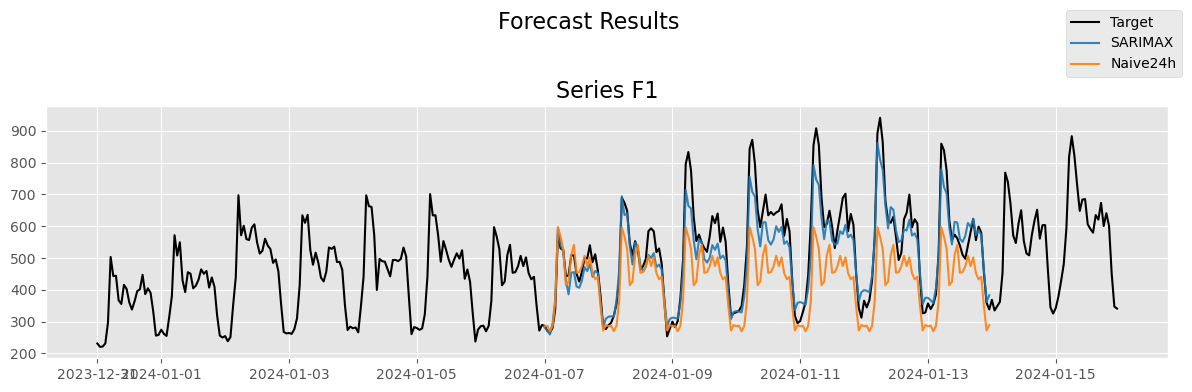

In [ ]:
# Pick an id
id = 'F1'

# Initialize configuration for the desired data preparation
sconfig = SARIMAXConfig(**sarimax_optimal_params[id])

# Create the SARIMAX pipeline with the specified configuration and generate the data
heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
spipeline = SARIMAXPipeline(
    target_df=heat_id_df,
    config=sconfig,
    aux_df=aux_id_df,
)
spipeline.prepare_data()

# Fit the SARIMAX model
start_train = pd.Timestamp('2023-01-06 23:00:00')
end_train = pd.Timestamp('2024-01-06 23:00:00')
spipeline.fit(
    end_train=end_train,
)

# Generate forecasts and plot the results
forecasts = spipeline.predict(h=24*7)
custom_plot_results(
    target_df=heat_id_df,
    forecast_df=forecasts,
    start_offset=24*7,
    end_offset=24*2,
    with_naive=True,
    target_train_df=heat_id_df[heat_id_df['ds'] <= end_train],
)

## Eample of cross validation

For completeness, here is an example of a simple fit + forecast with the SARIMAX custom pipeline.

In [ ]:
do_cv = True  # Set to False to skip cross-validation

# Pick an id
id = 'F1'

if do_cv:
    # Filter dataset for the chosen id
    heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
    aux_id_df = aux_df[aux_df['unique_id'] == id].copy()

    # Run get_cv_params to set the parameters for cross-validation
    n_windows = 15  
    h = 168        
    start_test_cv = pd.to_datetime('2023-11-01')
    end_test_cv = pd.to_datetime('2024-04-01')
    cv_params = get_cv_params_v2(
        start_test_cv=start_test_cv,
        end_test_cv=end_test_cv,
        n_windows=n_windows,
        horizon_hours=h,
    )

    # Run the cross-validation with the SeasonalNaive model
    naive_model = SeasonalNaive(season_length=24, alias='Naive24h')
    sf = StatsForecast(models=[naive_model], freq='h')
    heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
    t0 = pd.Timestamp.now()
    cv_naive = sf.cross_validation(
        h=h,
        df=heat_id_df[heat_id_df['ds'] <= end_test_cv], # Use all data up to the end of the last forecast horizon
        n_windows=n_windows,
        step_size=step_size,  
        test_size=test_hours,  
        input_size=None,  
        refit=True,  
    )

    # Run the cross-validation with the SARIMAX model
    params = sarimax_optimal_params[id]
    sconfig = SARIMAXConfig(**params)
    spipeline = SARIMAXPipeline(
        target_df=heat_id_df,
        aux_df=aux_id_df,
        config=sconfig,
    )
    logging.info(f"Running cross-validation for SARIMAX...")
    t0 = pd.Timestamp.now()
    spipeline.prepare_data()
    cv_sarimax = spipeline.cross_validation(
        h=h,                   # Forecast horizon in hours
        test_size=test_hours,  # Test size in hours
        end_test=end_test_cv,  # End of the test period
        step_size=step_size,   # Step size in hours
        verbose=True,
        alias=f'SARIMAX',  # Alias for the model
        # NB: the input size is not used here, it should be specified in the SARIMAXConfig
    )
    t1 = pd.Timestamp.now()
    elapsed = (t1 - t0).total_seconds()
    logging.info(f"✓ Cross-validation completed.")
    logging.info(f"Elapsed time: {elapsed:.2f} seconds")
    cv_sarimax.drop(columns=['y'], inplace=True)

    # Combine the results of the cross-validation
    key_cols = ["unique_id", "ds", "cutoff"]
    cv_df = pd.merge(
        cv_naive, cv_sarimax, on=key_cols, how="outer"
    )

18:21:29 | INFO | heat_forecast.utils.cv_utils | CV params: 15 windows, first cutoff 2023-11-14 23:00:00, last cutoff 2024-03-19 23:00:00, step size 9d 0h.
18:21:29 | INFO | root | Running cross-validation for SARIMAX...


CV windows:   0%|          | 0/15 [00:00<?, ?it/s]

18:47:10 | INFO | root | ✓ Cross-validation completed.
18:47:10 | INFO | root | Elapsed time: 1541.14 seconds


In [ ]:
if do_cv:
    # Compute evaluation metrics and display the summary
    summary, combined_results = custom_evaluate_cv(
        cv_df=cv_df,
        metrics=['mae', 'rmse', 'mase', 'nmae'],  # List of metrics to compute
        target_df=heat_df,  # Training data mase
    )
    _ = display_cv_summary(summary)

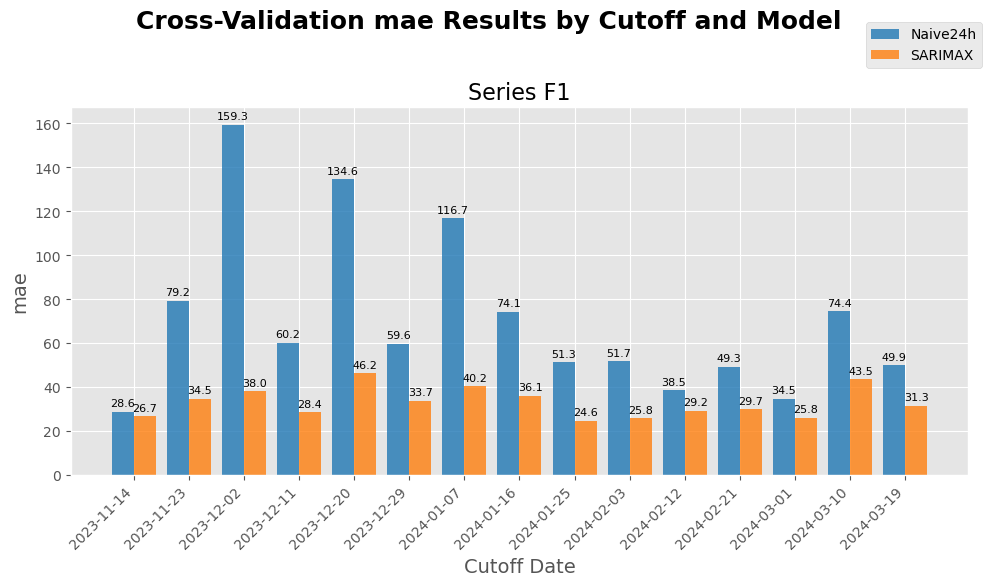

In [ ]:
if do_cv:
    # Plot the cross-validation metrics by cutoff
    fig = plotly_cv_metric_by_cutoff(
        combined_results=combined_results,
        metric='mae',  # Change to 'rmse' or 'me' for other metrics
        figsize=(10,6)
    )